In [182]:
import pandas as pd;
import numpy as np;
import matplotlib.pyplot as plt;
import os;
from pybedtools import BedTool;
import subprocess;
import math;

In [183]:
CELLS = ["Monocyte", "acute_myeloid_leukemia_blast_cell", "acute_myeloid_leukemia_leukmeia_stem_cell", "lymphoid_primed_multipotent_progenitor"]
EXPERIMENT_FOLDER = "/mnt/stripe/dievsky/GSE74310"
MACS2_PS = ["0.001", "0.0001", "0.00001"]
# discover MACS2 peak files
macs2_peaks_paths = {}
for cell in CELLS:
    macs2_peaks_paths[cell] = {macs2_p: os.path.join(EXPERIMENT_FOLDER, "cleaned_cell_peaks", "macs2",
                                                     macs2_p, "{}_peaks.narrowPeak".format(cell))
                               for macs2_p in MACS2_PS}
macs2_peaks_paths["total_pooled_data"] = {macs2_p: os.path.join(EXPERIMENT_FOLDER, "cleaned_all_peaks", "macs2",
                                                   macs2_p, "pooled_peaks.narrowPeak")
                                          for macs2_p in MACS2_PS}
# discover Span model files and BAMs
SPAN_BINS = ["50", "100", "200"]
span_model_paths = {}
bam_paths = {}
for cell in CELLS:
    bam_paths[cell] = os.path.join(EXPERIMENT_FOLDER, "cleaned_cells", "{}.bam".format(cell))
    span_model_paths[cell] = {span_bin: os.path.join(EXPERIMENT_FOLDER, "cleaned_cell_peaks", "span_keep_dup_0_old", "{}_{}.span".format(cell, span_bin)) for span_bin in SPAN_BINS}
bam_paths["total_pooled_data"] = os.path.join(EXPERIMENT_FOLDER, "cleaned_all", "pooled.bam")
span_model_paths["total_pooled_data"] = {span_bin: os.path.join(EXPERIMENT_FOLDER, "cleaned_all_peaks", "span_keep_dup_0_old", "pooled_{}.span".format(span_bin)) for span_bin in SPAN_BINS}
SPAN_JAR = os.path.join(EXPERIMENT_FOLDER, "bin", "span-0.10.0.build.jar")
CELLS.append('total_pooled_data')
# discover monocyte DHSs
MONOCYTE_DHS_PATH = os.path.join(EXPERIMENT_FOLDER, "dhs", "monocyte_cd14_dnase_tab.bed")
monocyte_dhs_file = BedTool(MONOCYTE_DHS_PATH)
monocyte_dhs_count = monocyte_dhs_file.count()
CHROM_SIZES = os.path.join(EXPERIMENT_FOLDER, "hg19.chrom.sizes")

In [184]:
main_dataframe = pd.DataFrame(columns=['peak_caller', 'cell', 'p', 'bin', 'fdr', 'gap',
                                       'peak_count', 'dhs_by_peak', 'peak_by_dhs'])

In [185]:
# populate MACS2 entries
for cell in CELLS:
    for macs2_p in MACS2_PS:
        print("Processing {} for p={}".format(cell, macs2_p))
        peaks_file = BedTool(macs2_peaks_paths[cell][macs2_p])
        peak_count = peaks_file.count()
        if cell == 'Monocyte':
            overlap = peaks_file.intersect(monocyte_dhs_file, wa=True, u=True).count()
            peak_by_dhs = overlap * 100.0 / peak_count            
            overlap = monocyte_dhs_file.intersect(peaks_file, wa=True, u=True).count()
            dhs_by_peak = overlap * 100.0 / monocyte_dhs_count
        else:
            dhs_by_peak = math.nan
            peak_by_dhs = math.nan        
        main_dataframe.loc[len(main_dataframe)] = ('macs2', cell, float(macs2_p), math.nan, math.nan, math.nan,
                                                   peak_count, dhs_by_peak, peak_by_dhs)
main_dataframe.head()

Processing Monocyte for p=0.001
Processing Monocyte for p=0.0001
Processing Monocyte for p=0.00001
Processing acute_myeloid_leukemia_blast_cell for p=0.001
Processing acute_myeloid_leukemia_blast_cell for p=0.0001
Processing acute_myeloid_leukemia_blast_cell for p=0.00001
Processing acute_myeloid_leukemia_leukmeia_stem_cell for p=0.001
Processing acute_myeloid_leukemia_leukmeia_stem_cell for p=0.0001
Processing acute_myeloid_leukemia_leukmeia_stem_cell for p=0.00001
Processing lymphoid_primed_multipotent_progenitor for p=0.001
Processing lymphoid_primed_multipotent_progenitor for p=0.0001
Processing lymphoid_primed_multipotent_progenitor for p=0.00001
Processing total_pooled_data for p=0.001
Processing total_pooled_data for p=0.0001
Processing total_pooled_data for p=0.00001


,peak_caller,cell,p,bin,fdr,gap,peak_count,dhs_by_peak,peak_by_dhs
0,macs2,Monocyte,0.00100,NaN,NaN,NaN,82876,40.248194,45.305034
1,macs2,Monocyte,0.00010,NaN,NaN,NaN,28372,26.867353,88.495700
2,macs2,Monocyte,0.00001,NaN,NaN,NaN,19224,19.706219,97.071369
3,macs2,acute_myeloid_leukemia_blast_cell,0.00100,NaN,NaN,NaN,43227,NaN,NaN
4,macs2,acute_myeloid_leukemia_blast_cell,0.00010,NaN,NaN,NaN,43227,NaN,NaN


In [186]:
# populate Span entries -- takes 1+ hour
SPAN_FDRS = ["0.5", "0.1", "0.01", "1E-4", "1E-6", "1E-9", "1E-12"]
SPAN_GAPS = ["0", "2", "5"]
for cell in CELLS:
    bam_path = bam_paths[cell]
    for span_bin in SPAN_BINS:    
        model_path = span_model_paths[cell][span_bin]
        work_dir = os.path.dirname(model_path)
        for span_fdr in SPAN_FDRS:
            for span_gap in SPAN_GAPS:
                peaks_path = "/tmp/span_peaks.bed"
                command = ('java -jar {} analyze -t {} --chrom.sizes {} --model {} --bin {} '
                           '--keep-dup --fragment 0 '
                           '--fdr {} --gap {} --peaks {} --workdir {} --threads 8').format(
                    SPAN_JAR, bam_path, CHROM_SIZES, model_path, span_bin, span_fdr, span_gap, peaks_path, work_dir)
                print('Running ' + command)
                subprocess.run(command, shell=True, check=True)
                peaks_file = BedTool(peaks_path)
                peak_count = peaks_file.count()
                print(peak_count)
                if cell == 'Monocyte':
                    overlap = peaks_file.intersect(monocyte_dhs_file, wa=True, u=True).count()
                    print(overlap)
                    peak_by_dhs = overlap * 100.0 / peak_count
                    overlap = monocyte_dhs_file.intersect(peaks_file, wa=True, u=True).count()
                    print(overlap)
                    dhs_by_peak = overlap * 100.0 / monocyte_dhs_count
                else:
                    peak_by_dhs = math.nan
                    dhs_by_peak = math.nan
                main_dataframe.loc[len(main_dataframe)] = ('span', cell, math.nan, int(span_bin), float(span_fdr),
                                                           int(span_gap), peak_count, dhs_by_peak, peak_by_dhs)

Running java -jar /mnt/stripe/dievsky/GSE74310/bin/span-0.10.0.build.jar analyze -t /mnt/stripe/dievsky/GSE74310/cleaned_cells/Monocyte.bam --chrom.sizes /mnt/stripe/dievsky/GSE74310/hg19.chrom.sizes --model /mnt/stripe/dievsky/GSE74310/cleaned_cell_peaks/span_keep_dup_0_old/Monocyte_50.span --bin 50 --keep-dup --fragment 0 --fdr 0.5 --gap 0 --peaks /tmp/span_peaks.bed --workdir /mnt/stripe/dievsky/GSE74310/cleaned_cell_peaks/span_keep_dup_0_old --threads 8
93949
51005
65492
Running java -jar /mnt/stripe/dievsky/GSE74310/bin/span-0.10.0.build.jar analyze -t /mnt/stripe/dievsky/GSE74310/cleaned_cells/Monocyte.bam --chrom.sizes /mnt/stripe/dievsky/GSE74310/hg19.chrom.sizes --model /mnt/stripe/dievsky/GSE74310/cleaned_cell_peaks/span_keep_dup_0_old/Monocyte_50.span --bin 50 --keep-dup --fragment 0 --fdr 0.5 --gap 2 --peaks /tmp/span_peaks.bed --workdir /mnt/stripe/dievsky/GSE74310/cleaned_cell_peaks/span_keep_dup_0_old --threads 8
92018
50719
65492
Running java -jar /mnt/stripe/dievsky/GS

20345
19826
21551
Running java -jar /mnt/stripe/dievsky/GSE74310/bin/span-0.10.0.build.jar analyze -t /mnt/stripe/dievsky/GSE74310/cleaned_cells/Monocyte.bam --chrom.sizes /mnt/stripe/dievsky/GSE74310/hg19.chrom.sizes --model /mnt/stripe/dievsky/GSE74310/cleaned_cell_peaks/span_keep_dup_0_old/Monocyte_50.span --bin 50 --keep-dup --fragment 0 --fdr 1E-12 --gap 0 --peaks /tmp/span_peaks.bed --workdir /mnt/stripe/dievsky/GSE74310/cleaned_cell_peaks/span_keep_dup_0_old --threads 8
19569
17075
15567
Running java -jar /mnt/stripe/dievsky/GSE74310/bin/span-0.10.0.build.jar analyze -t /mnt/stripe/dievsky/GSE74310/cleaned_cells/Monocyte.bam --chrom.sizes /mnt/stripe/dievsky/GSE74310/hg19.chrom.sizes --model /mnt/stripe/dievsky/GSE74310/cleaned_cell_peaks/span_keep_dup_0_old/Monocyte_50.span --bin 50 --keep-dup --fragment 0 --fdr 1E-12 --gap 2 --peaks /tmp/span_peaks.bed --workdir /mnt/stripe/dievsky/GSE74310/cleaned_cell_peaks/span_keep_dup_0_old --threads 8
16237
15380
15567
Running java -jar 

28962
27796
31641
Running java -jar /mnt/stripe/dievsky/GSE74310/bin/span-0.10.0.build.jar analyze -t /mnt/stripe/dievsky/GSE74310/cleaned_cells/Monocyte.bam --chrom.sizes /mnt/stripe/dievsky/GSE74310/hg19.chrom.sizes --model /mnt/stripe/dievsky/GSE74310/cleaned_cell_peaks/span_keep_dup_0_old/Monocyte_100.span --bin 100 --keep-dup --fragment 0 --fdr 1E-6 --gap 5 --peaks /tmp/span_peaks.bed --workdir /mnt/stripe/dievsky/GSE74310/cleaned_cell_peaks/span_keep_dup_0_old --threads 8
27277
26338
31719
Running java -jar /mnt/stripe/dievsky/GSE74310/bin/span-0.10.0.build.jar analyze -t /mnt/stripe/dievsky/GSE74310/cleaned_cells/Monocyte.bam --chrom.sizes /mnt/stripe/dievsky/GSE74310/hg19.chrom.sizes --model /mnt/stripe/dievsky/GSE74310/cleaned_cell_peaks/span_keep_dup_0_old/Monocyte_100.span --bin 100 --keep-dup --fragment 0 --fdr 1E-9 --gap 0 --peaks /tmp/span_peaks.bed --workdir /mnt/stripe/dievsky/GSE74310/cleaned_cell_peaks/span_keep_dup_0_old --threads 8
26563
24417
24649
Running java -ja

37247
33790
40198
Running java -jar /mnt/stripe/dievsky/GSE74310/bin/span-0.10.0.build.jar analyze -t /mnt/stripe/dievsky/GSE74310/cleaned_cells/Monocyte.bam --chrom.sizes /mnt/stripe/dievsky/GSE74310/hg19.chrom.sizes --model /mnt/stripe/dievsky/GSE74310/cleaned_cell_peaks/span_keep_dup_0_old/Monocyte_200.span --bin 200 --keep-dup --fragment 0 --fdr 1E-4 --gap 2 --peaks /tmp/span_peaks.bed --workdir /mnt/stripe/dievsky/GSE74310/cleaned_cell_peaks/span_keep_dup_0_old --threads 8
33742
31252
40288
Running java -jar /mnt/stripe/dievsky/GSE74310/bin/span-0.10.0.build.jar analyze -t /mnt/stripe/dievsky/GSE74310/cleaned_cells/Monocyte.bam --chrom.sizes /mnt/stripe/dievsky/GSE74310/hg19.chrom.sizes --model /mnt/stripe/dievsky/GSE74310/cleaned_cell_peaks/span_keep_dup_0_old/Monocyte_200.span --bin 200 --keep-dup --fragment 0 --fdr 1E-4 --gap 5 --peaks /tmp/span_peaks.bed --workdir /mnt/stripe/dievsky/GSE74310/cleaned_cell_peaks/span_keep_dup_0_old --threads 8
31810
29639
40702
Running java -ja

332865
Running java -jar /mnt/stripe/dievsky/GSE74310/bin/span-0.10.0.build.jar analyze -t /mnt/stripe/dievsky/GSE74310/cleaned_cells/acute_myeloid_leukemia_blast_cell.bam --chrom.sizes /mnt/stripe/dievsky/GSE74310/hg19.chrom.sizes --model /mnt/stripe/dievsky/GSE74310/cleaned_cell_peaks/span_keep_dup_0_old/acute_myeloid_leukemia_blast_cell_50.span --bin 50 --keep-dup --fragment 0 --fdr 0.01 --gap 0 --peaks /tmp/span_peaks.bed --workdir /mnt/stripe/dievsky/GSE74310/cleaned_cell_peaks/span_keep_dup_0_old --threads 8
407183
Running java -jar /mnt/stripe/dievsky/GSE74310/bin/span-0.10.0.build.jar analyze -t /mnt/stripe/dievsky/GSE74310/cleaned_cells/acute_myeloid_leukemia_blast_cell.bam --chrom.sizes /mnt/stripe/dievsky/GSE74310/hg19.chrom.sizes --model /mnt/stripe/dievsky/GSE74310/cleaned_cell_peaks/span_keep_dup_0_old/acute_myeloid_leukemia_blast_cell_50.span --bin 50 --keep-dup --fragment 0 --fdr 0.01 --gap 2 --peaks /tmp/span_peaks.bed --workdir /mnt/stripe/dievsky/GSE74310/cleaned_cel

72306
Running java -jar /mnt/stripe/dievsky/GSE74310/bin/span-0.10.0.build.jar analyze -t /mnt/stripe/dievsky/GSE74310/cleaned_cells/acute_myeloid_leukemia_blast_cell.bam --chrom.sizes /mnt/stripe/dievsky/GSE74310/hg19.chrom.sizes --model /mnt/stripe/dievsky/GSE74310/cleaned_cell_peaks/span_keep_dup_0_old/acute_myeloid_leukemia_blast_cell_100.span --bin 100 --keep-dup --fragment 0 --fdr 0.5 --gap 2 --peaks /tmp/span_peaks.bed --workdir /mnt/stripe/dievsky/GSE74310/cleaned_cell_peaks/span_keep_dup_0_old --threads 8
69822
Running java -jar /mnt/stripe/dievsky/GSE74310/bin/span-0.10.0.build.jar analyze -t /mnt/stripe/dievsky/GSE74310/cleaned_cells/acute_myeloid_leukemia_blast_cell.bam --chrom.sizes /mnt/stripe/dievsky/GSE74310/hg19.chrom.sizes --model /mnt/stripe/dievsky/GSE74310/cleaned_cell_peaks/span_keep_dup_0_old/acute_myeloid_leukemia_blast_cell_100.span --bin 100 --keep-dup --fragment 0 --fdr 0.5 --gap 5 --peaks /tmp/span_peaks.bed --workdir /mnt/stripe/dievsky/GSE74310/cleaned_cel

12759
Running java -jar /mnt/stripe/dievsky/GSE74310/bin/span-0.10.0.build.jar analyze -t /mnt/stripe/dievsky/GSE74310/cleaned_cells/acute_myeloid_leukemia_blast_cell.bam --chrom.sizes /mnt/stripe/dievsky/GSE74310/hg19.chrom.sizes --model /mnt/stripe/dievsky/GSE74310/cleaned_cell_peaks/span_keep_dup_0_old/acute_myeloid_leukemia_blast_cell_100.span --bin 100 --keep-dup --fragment 0 --fdr 1E-9 --gap 5 --peaks /tmp/span_peaks.bed --workdir /mnt/stripe/dievsky/GSE74310/cleaned_cell_peaks/span_keep_dup_0_old --threads 8
12211
Running java -jar /mnt/stripe/dievsky/GSE74310/bin/span-0.10.0.build.jar analyze -t /mnt/stripe/dievsky/GSE74310/cleaned_cells/acute_myeloid_leukemia_blast_cell.bam --chrom.sizes /mnt/stripe/dievsky/GSE74310/hg19.chrom.sizes --model /mnt/stripe/dievsky/GSE74310/cleaned_cell_peaks/span_keep_dup_0_old/acute_myeloid_leukemia_blast_cell_100.span --bin 100 --keep-dup --fragment 0 --fdr 1E-12 --gap 0 --peaks /tmp/span_peaks.bed --workdir /mnt/stripe/dievsky/GSE74310/cleaned_

24787
Running java -jar /mnt/stripe/dievsky/GSE74310/bin/span-0.10.0.build.jar analyze -t /mnt/stripe/dievsky/GSE74310/cleaned_cells/acute_myeloid_leukemia_blast_cell.bam --chrom.sizes /mnt/stripe/dievsky/GSE74310/hg19.chrom.sizes --model /mnt/stripe/dievsky/GSE74310/cleaned_cell_peaks/span_keep_dup_0_old/acute_myeloid_leukemia_blast_cell_200.span --bin 200 --keep-dup --fragment 0 --fdr 1E-6 --gap 0 --peaks /tmp/span_peaks.bed --workdir /mnt/stripe/dievsky/GSE74310/cleaned_cell_peaks/span_keep_dup_0_old --threads 8
22632
Running java -jar /mnt/stripe/dievsky/GSE74310/bin/span-0.10.0.build.jar analyze -t /mnt/stripe/dievsky/GSE74310/cleaned_cells/acute_myeloid_leukemia_blast_cell.bam --chrom.sizes /mnt/stripe/dievsky/GSE74310/hg19.chrom.sizes --model /mnt/stripe/dievsky/GSE74310/cleaned_cell_peaks/span_keep_dup_0_old/acute_myeloid_leukemia_blast_cell_200.span --bin 200 --keep-dup --fragment 0 --fdr 1E-6 --gap 2 --peaks /tmp/span_peaks.bed --workdir /mnt/stripe/dievsky/GSE74310/cleaned_c

303675
Running java -jar /mnt/stripe/dievsky/GSE74310/bin/span-0.10.0.build.jar analyze -t /mnt/stripe/dievsky/GSE74310/cleaned_cells/acute_myeloid_leukemia_leukmeia_stem_cell.bam --chrom.sizes /mnt/stripe/dievsky/GSE74310/hg19.chrom.sizes --model /mnt/stripe/dievsky/GSE74310/cleaned_cell_peaks/span_keep_dup_0_old/acute_myeloid_leukemia_leukmeia_stem_cell_50.span --bin 50 --keep-dup --fragment 0 --fdr 0.01 --gap 2 --peaks /tmp/span_peaks.bed --workdir /mnt/stripe/dievsky/GSE74310/cleaned_cell_peaks/span_keep_dup_0_old --threads 8
302972
Running java -jar /mnt/stripe/dievsky/GSE74310/bin/span-0.10.0.build.jar analyze -t /mnt/stripe/dievsky/GSE74310/cleaned_cells/acute_myeloid_leukemia_leukmeia_stem_cell.bam --chrom.sizes /mnt/stripe/dievsky/GSE74310/hg19.chrom.sizes --model /mnt/stripe/dievsky/GSE74310/cleaned_cell_peaks/span_keep_dup_0_old/acute_myeloid_leukemia_leukmeia_stem_cell_50.span --bin 50 --keep-dup --fragment 0 --fdr 0.01 --gap 5 --peaks /tmp/span_peaks.bed --workdir /mnt/str

222691
Running java -jar /mnt/stripe/dievsky/GSE74310/bin/span-0.10.0.build.jar analyze -t /mnt/stripe/dievsky/GSE74310/cleaned_cells/acute_myeloid_leukemia_leukmeia_stem_cell.bam --chrom.sizes /mnt/stripe/dievsky/GSE74310/hg19.chrom.sizes --model /mnt/stripe/dievsky/GSE74310/cleaned_cell_peaks/span_keep_dup_0_old/acute_myeloid_leukemia_leukmeia_stem_cell_100.span --bin 100 --keep-dup --fragment 0 --fdr 0.5 --gap 5 --peaks /tmp/span_peaks.bed --workdir /mnt/stripe/dievsky/GSE74310/cleaned_cell_peaks/span_keep_dup_0_old --threads 8
216116
Running java -jar /mnt/stripe/dievsky/GSE74310/bin/span-0.10.0.build.jar analyze -t /mnt/stripe/dievsky/GSE74310/cleaned_cells/acute_myeloid_leukemia_leukmeia_stem_cell.bam --chrom.sizes /mnt/stripe/dievsky/GSE74310/hg19.chrom.sizes --model /mnt/stripe/dievsky/GSE74310/cleaned_cell_peaks/span_keep_dup_0_old/acute_myeloid_leukemia_leukmeia_stem_cell_100.span --bin 100 --keep-dup --fragment 0 --fdr 0.1 --gap 0 --peaks /tmp/span_peaks.bed --workdir /mnt/s

274893
Running java -jar /mnt/stripe/dievsky/GSE74310/bin/span-0.10.0.build.jar analyze -t /mnt/stripe/dievsky/GSE74310/cleaned_cells/acute_myeloid_leukemia_leukmeia_stem_cell.bam --chrom.sizes /mnt/stripe/dievsky/GSE74310/hg19.chrom.sizes --model /mnt/stripe/dievsky/GSE74310/cleaned_cell_peaks/span_keep_dup_0_old/acute_myeloid_leukemia_leukmeia_stem_cell_100.span --bin 100 --keep-dup --fragment 0 --fdr 1E-12 --gap 0 --peaks /tmp/span_peaks.bed --workdir /mnt/stripe/dievsky/GSE74310/cleaned_cell_peaks/span_keep_dup_0_old --threads 8
535469
Running java -jar /mnt/stripe/dievsky/GSE74310/bin/span-0.10.0.build.jar analyze -t /mnt/stripe/dievsky/GSE74310/cleaned_cells/acute_myeloid_leukemia_leukmeia_stem_cell.bam --chrom.sizes /mnt/stripe/dievsky/GSE74310/hg19.chrom.sizes --model /mnt/stripe/dievsky/GSE74310/cleaned_cell_peaks/span_keep_dup_0_old/acute_myeloid_leukemia_leukmeia_stem_cell_100.span --bin 100 --keep-dup --fragment 0 --fdr 1E-12 --gap 2 --peaks /tmp/span_peaks.bed --workdir /m

375725
Running java -jar /mnt/stripe/dievsky/GSE74310/bin/span-0.10.0.build.jar analyze -t /mnt/stripe/dievsky/GSE74310/cleaned_cells/acute_myeloid_leukemia_leukmeia_stem_cell.bam --chrom.sizes /mnt/stripe/dievsky/GSE74310/hg19.chrom.sizes --model /mnt/stripe/dievsky/GSE74310/cleaned_cell_peaks/span_keep_dup_0_old/acute_myeloid_leukemia_leukmeia_stem_cell_200.span --bin 200 --keep-dup --fragment 0 --fdr 1E-6 --gap 2 --peaks /tmp/span_peaks.bed --workdir /mnt/stripe/dievsky/GSE74310/cleaned_cell_peaks/span_keep_dup_0_old --threads 8
270595
Running java -jar /mnt/stripe/dievsky/GSE74310/bin/span-0.10.0.build.jar analyze -t /mnt/stripe/dievsky/GSE74310/cleaned_cells/acute_myeloid_leukemia_leukmeia_stem_cell.bam --chrom.sizes /mnt/stripe/dievsky/GSE74310/hg19.chrom.sizes --model /mnt/stripe/dievsky/GSE74310/cleaned_cell_peaks/span_keep_dup_0_old/acute_myeloid_leukemia_leukmeia_stem_cell_200.span --bin 200 --keep-dup --fragment 0 --fdr 1E-6 --gap 5 --peaks /tmp/span_peaks.bed --workdir /mnt

225338
Running java -jar /mnt/stripe/dievsky/GSE74310/bin/span-0.10.0.build.jar analyze -t /mnt/stripe/dievsky/GSE74310/cleaned_cells/lymphoid_primed_multipotent_progenitor.bam --chrom.sizes /mnt/stripe/dievsky/GSE74310/hg19.chrom.sizes --model /mnt/stripe/dievsky/GSE74310/cleaned_cell_peaks/span_keep_dup_0_old/lymphoid_primed_multipotent_progenitor_50.span --bin 50 --keep-dup --fragment 0 --fdr 0.01 --gap 5 --peaks /tmp/span_peaks.bed --workdir /mnt/stripe/dievsky/GSE74310/cleaned_cell_peaks/span_keep_dup_0_old --threads 8
221161
Running java -jar /mnt/stripe/dievsky/GSE74310/bin/span-0.10.0.build.jar analyze -t /mnt/stripe/dievsky/GSE74310/cleaned_cells/lymphoid_primed_multipotent_progenitor.bam --chrom.sizes /mnt/stripe/dievsky/GSE74310/hg19.chrom.sizes --model /mnt/stripe/dievsky/GSE74310/cleaned_cell_peaks/span_keep_dup_0_old/lymphoid_primed_multipotent_progenitor_50.span --bin 50 --keep-dup --fragment 0 --fdr 1E-4 --gap 0 --peaks /tmp/span_peaks.bed --workdir /mnt/stripe/dievsky/

167285
Running java -jar /mnt/stripe/dievsky/GSE74310/bin/span-0.10.0.build.jar analyze -t /mnt/stripe/dievsky/GSE74310/cleaned_cells/lymphoid_primed_multipotent_progenitor.bam --chrom.sizes /mnt/stripe/dievsky/GSE74310/hg19.chrom.sizes --model /mnt/stripe/dievsky/GSE74310/cleaned_cell_peaks/span_keep_dup_0_old/lymphoid_primed_multipotent_progenitor_100.span --bin 100 --keep-dup --fragment 0 --fdr 0.1 --gap 0 --peaks /tmp/span_peaks.bed --workdir /mnt/stripe/dievsky/GSE74310/cleaned_cell_peaks/span_keep_dup_0_old --threads 8
197398
Running java -jar /mnt/stripe/dievsky/GSE74310/bin/span-0.10.0.build.jar analyze -t /mnt/stripe/dievsky/GSE74310/cleaned_cells/lymphoid_primed_multipotent_progenitor.bam --chrom.sizes /mnt/stripe/dievsky/GSE74310/hg19.chrom.sizes --model /mnt/stripe/dievsky/GSE74310/cleaned_cell_peaks/span_keep_dup_0_old/lymphoid_primed_multipotent_progenitor_100.span --bin 100 --keep-dup --fragment 0 --fdr 0.1 --gap 2 --peaks /tmp/span_peaks.bed --workdir /mnt/stripe/dievsk

401679
Running java -jar /mnt/stripe/dievsky/GSE74310/bin/span-0.10.0.build.jar analyze -t /mnt/stripe/dievsky/GSE74310/cleaned_cells/lymphoid_primed_multipotent_progenitor.bam --chrom.sizes /mnt/stripe/dievsky/GSE74310/hg19.chrom.sizes --model /mnt/stripe/dievsky/GSE74310/cleaned_cell_peaks/span_keep_dup_0_old/lymphoid_primed_multipotent_progenitor_100.span --bin 100 --keep-dup --fragment 0 --fdr 1E-12 --gap 2 --peaks /tmp/span_peaks.bed --workdir /mnt/stripe/dievsky/GSE74310/cleaned_cell_peaks/span_keep_dup_0_old --threads 8
254334
Running java -jar /mnt/stripe/dievsky/GSE74310/bin/span-0.10.0.build.jar analyze -t /mnt/stripe/dievsky/GSE74310/cleaned_cells/lymphoid_primed_multipotent_progenitor.bam --chrom.sizes /mnt/stripe/dievsky/GSE74310/hg19.chrom.sizes --model /mnt/stripe/dievsky/GSE74310/cleaned_cell_peaks/span_keep_dup_0_old/lymphoid_primed_multipotent_progenitor_100.span --bin 100 --keep-dup --fragment 0 --fdr 1E-12 --gap 5 --peaks /tmp/span_peaks.bed --workdir /mnt/stripe/di

205808
Running java -jar /mnt/stripe/dievsky/GSE74310/bin/span-0.10.0.build.jar analyze -t /mnt/stripe/dievsky/GSE74310/cleaned_cells/lymphoid_primed_multipotent_progenitor.bam --chrom.sizes /mnt/stripe/dievsky/GSE74310/hg19.chrom.sizes --model /mnt/stripe/dievsky/GSE74310/cleaned_cell_peaks/span_keep_dup_0_old/lymphoid_primed_multipotent_progenitor_200.span --bin 200 --keep-dup --fragment 0 --fdr 1E-6 --gap 5 --peaks /tmp/span_peaks.bed --workdir /mnt/stripe/dievsky/GSE74310/cleaned_cell_peaks/span_keep_dup_0_old --threads 8
179318
Running java -jar /mnt/stripe/dievsky/GSE74310/bin/span-0.10.0.build.jar analyze -t /mnt/stripe/dievsky/GSE74310/cleaned_cells/lymphoid_primed_multipotent_progenitor.bam --chrom.sizes /mnt/stripe/dievsky/GSE74310/hg19.chrom.sizes --model /mnt/stripe/dievsky/GSE74310/cleaned_cell_peaks/span_keep_dup_0_old/lymphoid_primed_multipotent_progenitor_200.span --bin 200 --keep-dup --fragment 0 --fdr 1E-9 --gap 0 --peaks /tmp/span_peaks.bed --workdir /mnt/stripe/diev

91999
Running java -jar /mnt/stripe/dievsky/GSE74310/bin/span-0.10.0.build.jar analyze -t /mnt/stripe/dievsky/GSE74310/cleaned_all/pooled.bam --chrom.sizes /mnt/stripe/dievsky/GSE74310/hg19.chrom.sizes --model /mnt/stripe/dievsky/GSE74310/cleaned_all_peaks/span_keep_dup_0_old/pooled_50.span --bin 50 --keep-dup --fragment 0 --fdr 1E-4 --gap 2 --peaks /tmp/span_peaks.bed --workdir /mnt/stripe/dievsky/GSE74310/cleaned_all_peaks/span_keep_dup_0_old --threads 8
74934
Running java -jar /mnt/stripe/dievsky/GSE74310/bin/span-0.10.0.build.jar analyze -t /mnt/stripe/dievsky/GSE74310/cleaned_all/pooled.bam --chrom.sizes /mnt/stripe/dievsky/GSE74310/hg19.chrom.sizes --model /mnt/stripe/dievsky/GSE74310/cleaned_all_peaks/span_keep_dup_0_old/pooled_50.span --bin 50 --keep-dup --fragment 0 --fdr 1E-4 --gap 5 --peaks /tmp/span_peaks.bed --workdir /mnt/stripe/dievsky/GSE74310/cleaned_all_peaks/span_keep_dup_0_old --threads 8
67544
Running java -jar /mnt/stripe/dievsky/GSE74310/bin/span-0.10.0.build.jar

82842
Running java -jar /mnt/stripe/dievsky/GSE74310/bin/span-0.10.0.build.jar analyze -t /mnt/stripe/dievsky/GSE74310/cleaned_all/pooled.bam --chrom.sizes /mnt/stripe/dievsky/GSE74310/hg19.chrom.sizes --model /mnt/stripe/dievsky/GSE74310/cleaned_all_peaks/span_keep_dup_0_old/pooled_100.span --bin 100 --keep-dup --fragment 0 --fdr 0.01 --gap 2 --peaks /tmp/span_peaks.bed --workdir /mnt/stripe/dievsky/GSE74310/cleaned_all_peaks/span_keep_dup_0_old --threads 8
81706
Running java -jar /mnt/stripe/dievsky/GSE74310/bin/span-0.10.0.build.jar analyze -t /mnt/stripe/dievsky/GSE74310/cleaned_all/pooled.bam --chrom.sizes /mnt/stripe/dievsky/GSE74310/hg19.chrom.sizes --model /mnt/stripe/dievsky/GSE74310/cleaned_all_peaks/span_keep_dup_0_old/pooled_100.span --bin 100 --keep-dup --fragment 0 --fdr 0.01 --gap 5 --peaks /tmp/span_peaks.bed --workdir /mnt/stripe/dievsky/GSE74310/cleaned_all_peaks/span_keep_dup_0_old --threads 8
78628
Running java -jar /mnt/stripe/dievsky/GSE74310/bin/span-0.10.0.build

97859
Running java -jar /mnt/stripe/dievsky/GSE74310/bin/span-0.10.0.build.jar analyze -t /mnt/stripe/dievsky/GSE74310/cleaned_all/pooled.bam --chrom.sizes /mnt/stripe/dievsky/GSE74310/hg19.chrom.sizes --model /mnt/stripe/dievsky/GSE74310/cleaned_all_peaks/span_keep_dup_0_old/pooled_200.span --bin 200 --keep-dup --fragment 0 --fdr 0.1 --gap 2 --peaks /tmp/span_peaks.bed --workdir /mnt/stripe/dievsky/GSE74310/cleaned_all_peaks/span_keep_dup_0_old --threads 8
96471
Running java -jar /mnt/stripe/dievsky/GSE74310/bin/span-0.10.0.build.jar analyze -t /mnt/stripe/dievsky/GSE74310/cleaned_all/pooled.bam --chrom.sizes /mnt/stripe/dievsky/GSE74310/hg19.chrom.sizes --model /mnt/stripe/dievsky/GSE74310/cleaned_all_peaks/span_keep_dup_0_old/pooled_200.span --bin 200 --keep-dup --fragment 0 --fdr 0.1 --gap 5 --peaks /tmp/span_peaks.bed --workdir /mnt/stripe/dievsky/GSE74310/cleaned_all_peaks/span_keep_dup_0_old --threads 8
91660
Running java -jar /mnt/stripe/dievsky/GSE74310/bin/span-0.10.0.build.j

In [187]:
main_dataframe.describe()

,p,bin,fdr,gap,dhs_by_peak,peak_by_dhs
count,15.000000,315.000000,3.150000e+02,315.000000,66.000000,66.000000
mean,0.000370,116.666667,8.715729e-02,2.333333,35.102909,85.459698
std,0.000463,62.460178,1.722060e-01,2.058074,14.064271,14.070304
min,0.000010,50.000000,1.000000e-12,0.000000,13.594802,45.305034
25%,0.000010,50.000000,1.000000e-09,0.000000,23.262333,82.168317
50%,0.000100,100.000000,1.000000e-04,2.000000,33.685277,89.070588
75%,0.001000,200.000000,1.000000e-01,5.000000,44.860140,95.948330
max,0.001000,200.000000,5.000000e-01,5.000000,61.522876,99.040570


In [188]:
overlap_dataframe = main_dataframe[np.logical_not(np.isnan(main_dataframe['dhs_by_peak']))]
overlap_dataframe.describe()

,p,bin,fdr,gap,dhs_by_peak,peak_by_dhs
count,3.000000,63.000000,6.300000e+01,63.000000,66.000000,66.000000
mean,0.000370,116.666667,8.715729e-02,2.333333,35.102909,85.459698
std,0.000547,62.861856,1.733134e-01,2.071309,14.064271,14.070304
min,0.000010,50.000000,1.000000e-12,0.000000,13.594802,45.305034
25%,0.000055,50.000000,1.000000e-09,0.000000,23.262333,82.168317
50%,0.000100,100.000000,1.000000e-04,2.000000,33.685277,89.070588
75%,0.000550,200.000000,1.000000e-01,5.000000,44.860140,95.948330
max,0.001000,200.000000,5.000000e-01,5.000000,61.522876,99.040570


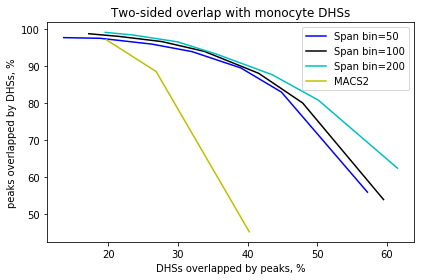

In [189]:
# Plot monocyte DHSs overlap
# Only gap=5 is considered for Span
COLORS_FOR_BINS = {'50': 'b', '100': 'k', '200': 'c'}
for span_bin in SPAN_BINS:
    span_overlap_dataframe = overlap_dataframe[np.logical_and(np.logical_and(overlap_dataframe['peak_caller'] == 'span',
                                                                             overlap_dataframe['gap'] == 5),
                                                              overlap_dataframe['bin'] == int(span_bin))]
    plt.plot(span_overlap_dataframe['dhs_by_peak'], span_overlap_dataframe['peak_by_dhs'], 
             COLORS_FOR_BINS[span_bin], label='Span bin=' + span_bin)
macs2_overlap_dataframe = overlap_dataframe[overlap_dataframe['peak_caller'] == 'macs2']
plt.plot(macs2_overlap_dataframe['dhs_by_peak'], macs2_overlap_dataframe['peak_by_dhs'], 'y', label='MACS2')
plt.legend()
plt.title("Two-sided overlap with monocyte DHSs")
plt.xlabel("DHSs overlapped by peaks, %")
plt.ylabel("peaks overlapped by DHSs, %")
plt.tight_layout()
plt.savefig('overlap_ROC.png', dpi=300)
plt.show()

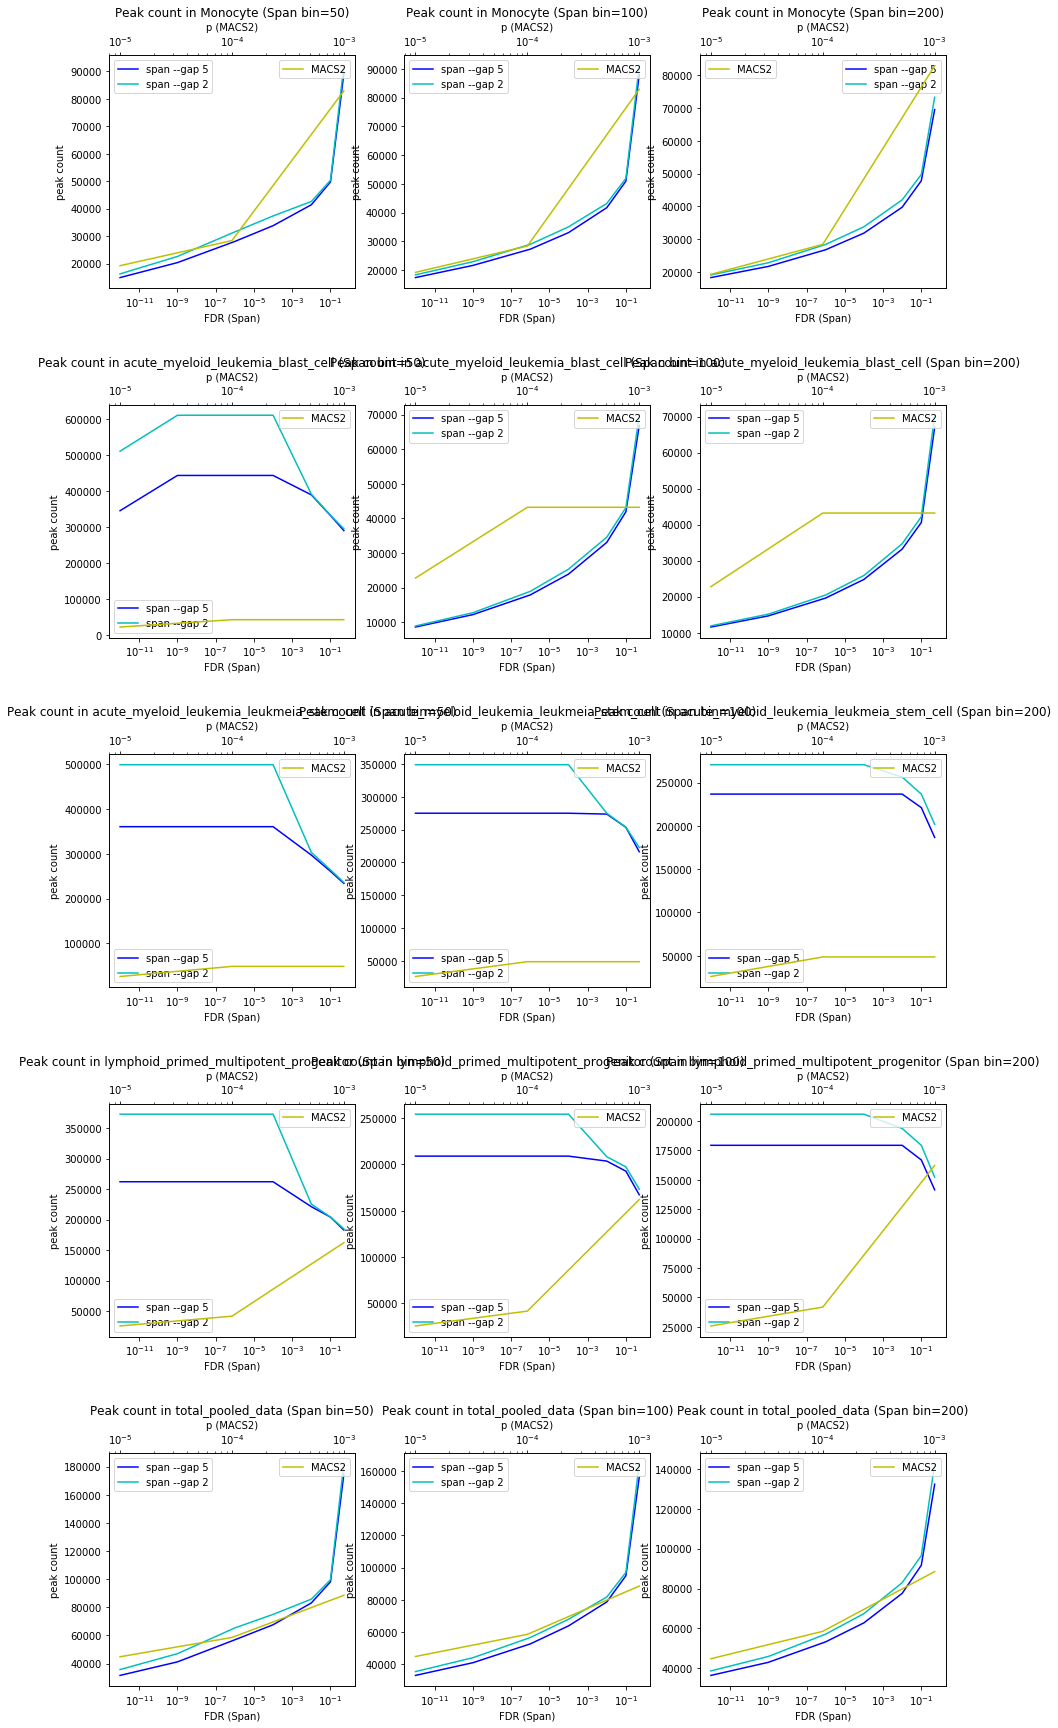

In [190]:
# Plot peak counts
# Note that leukemia stem cell and lymphoid progenitor failed to fit, as well as leukemia blast cell for bin=50
fig, span_axes_matrix = plt.subplots(len(CELLS), len(SPAN_BINS), sharex=False, sharey=False, figsize=(15, 6 * len(CELLS)))
for cell, span_axes_vector in zip(CELLS, span_axes_matrix):
    for span_bin, span_ax in zip(SPAN_BINS, span_axes_vector):
        peak_count_dataframe = main_dataframe[np.logical_and(main_dataframe['cell'] == cell,
                                                             np.logical_or(main_dataframe['peak_caller'] == 'macs2',
                                                                           main_dataframe['bin'] == int(span_bin)))]
        macs2_ax = span_ax.twiny()
        span_ax.set_xlabel('FDR (Span)')
        macs2_ax.set_xlabel('p (MACS2)')
        span_ax.set_xscale('log')
        macs2_ax.set_xscale('log')
        span_peak_count_5 = peak_count_dataframe[np.logical_and(peak_count_dataframe['peak_caller'] == 'span', peak_count_dataframe['gap'] == 5)]
        span_ax.plot(span_peak_count_5['fdr'], span_peak_count_5['peak_count'], 'b', label='span --gap 5')
        span_peak_count_2 = peak_count_dataframe[np.logical_and(peak_count_dataframe['peak_caller'] == 'span', peak_count_dataframe['gap'] == 2)]
        span_ax.plot(span_peak_count_2['fdr'], span_peak_count_2['peak_count'], 'c', label='span --gap 2')
        macs2_peak_count = peak_count_dataframe[peak_count_dataframe['peak_caller'] == 'macs2']
        macs2_ax.plot(macs2_peak_count['p'], macs2_peak_count['peak_count'], 'y', label='MACS2')
        span_ax.set_ylabel('peak count')
        span_ax.set_title('Peak count in ' + cell + ' (Span bin=' + span_bin + ')')        
        span_ax.legend()
        macs2_ax.legend()
fig.subplots_adjust(hspace=0.5)
fig.savefig("GSE74310_peak_count.png", dpi=300)
plt.show()